### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- The model can be applied to normal dynamic pipelay condition as a rough estimate

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import plotly.graph_objects as go

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 59.1       #  (submerged pipe weight) [kg/m]
N = 20       # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 168 # [m]
B = 46
H = 13.5
Xg = L/2 # [m]
mn = 39_989_000  # mass of the vessel, [kg]

In [8]:
Fx_0 = 604.76664*1000
Fy_0 = 0.7*Fx_0
LTD = 255.21207

In [9]:
lx, ly, lz = L/2, B/2, H/2

In [10]:
vessel_mass = mn/L # mass over length of the vessel

In [11]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [13]:
rho_steel=7850 #kg/m^3
rho_steel *= 9.81

In [14]:
Ar=np.pi*((d0/2)**2-(dI/2)**2) 
Iy_ = 1/4*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
Iz_ = 1/2*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
J_ = 1/32*np.pi*(d0**4-dI**4)

In [15]:
E = 207e9
G = 79.3e9

In [16]:
h = 40 # water depth

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [20]:
# Constants: 

In [21]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [22]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [23]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [24]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [25]:
# for testing:

In [26]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [27]:
φ

array([0.45651743, 0.41414681, 0.31580872, 0.82094024, 0.28660226,
       0.28952304, 0.14001567, 0.54449898, 0.08671805, 0.44892136,
       0.58870966, 0.02944185, 0.37472033, 0.36829056, 0.19373851,
       0.62542165, 0.89087699, 0.97075765, 0.80317435, 0.71547968])

In [28]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [29]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [30]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [31]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

In [32]:
# integration parameters
tspan = (0., 10)

coefs = [1, 1, 1, 1, 1, 1]
k500 = 6
lift_reduction_factor=1
vessel_motion_calibration_coefficient = 1e2 # to control dynamics

### Main functions:

In [33]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [34]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [35]:
Π(φ,θ,ψ)

array([[[ 0.86799137,  0.        ,  0.44572615],
        [ 0.        ,  1.        , -0.44082486],
        [-0.49657927,  0.        ,  0.7791031 ]],

       [[ 0.82875503,  0.        ,  0.51230199],
        [ 0.        ,  1.        , -0.40240901],
        [-0.55961156,  0.        ,  0.75869207]],

       [[ 0.94791733,  0.        ,  0.30276439],
        [ 0.        ,  1.        , -0.3105853 ],
        [-0.31851646,  0.        ,  0.90103857]],

       [[ 0.7281248 ,  0.        ,  0.46715341],
        [ 0.        ,  1.        , -0.73178696],
        [-0.68544458,  0.        ,  0.49624141]],

       [[ 0.6611676 ,  0.        ,  0.71963597],
        [ 0.        ,  1.        , -0.28269472],
        [-0.75023823,  0.        ,  0.63419853]],

       [[ 0.81933563,  0.        ,  0.54945291],
        [ 0.        ,  1.        , -0.28549514],
        [-0.57331416,  0.        ,  0.78523501]],

       [[ 0.99291334,  0.        ,  0.11767767],
        [ 0.        ,  1.        , -0.13955863],
        

In [36]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [37]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 1.17724322, -0.10019219,  0.09725552],
       [ 0.47789877,  0.22602967,  0.09181571],
       [ 1.23027192,  0.29757682,  0.57050079],
       [ 0.67536936, -0.53954261,  0.09899905],
       [ 0.31440751,  0.06924471,  0.06787577],
       [ 0.6469669 ,  0.35171018, -0.29078823],
       [ 0.6913792 ,  0.04926065,  0.52128057],
       [ 0.51032416,  0.78685758, -0.35553154],
       [ 0.2093135 ,  0.91234953,  0.88747543],
       [ 0.41388857, -0.20326735,  0.30255368],
       [ 0.46225617, -0.02596051,  0.37575561],
       [ 0.14862391,  0.87988148,  0.16602575],
       [ 0.6095785 , -0.14887042,  0.63136482],
       [ 1.12771208,  0.10934766,  0.35467716],
       [ 0.46551328,  0.93366768,  0.20511126],
       [ 0.2025147 ,  0.63401122,  0.45231944],
       [ 0.32439409, -0.31635086,  0.16932572],
       [ 0.14207793,  0.21777544,  0.08657097],
       [ 0.41537606,  0.0969268 , -0.262402  ],
       [ 0.51499726,  0.13168066,  0.52845349]])

In [38]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [39]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.53360751, -0.0628577 ,  0.34956837],
       [ 1.30555996,  0.23654721,  0.17302872],
       [ 2.11233224,  0.2710134 ,  0.39535094],
       [ 1.51306696, -0.67109331,  0.4844559 ],
       [ 0.97366209,  0.00226606,  0.20289163],
       [ 1.4889409 ,  0.6090698 , -0.36351393],
       [ 0.95526358,  0.58171035,  0.87815005],
       [ 1.08419942,  1.01889335, -0.29817063],
       [ 1.35160685,  1.09605599,  0.92750571],
       [ 0.7663406 ,  0.47790439,  0.37267388],
       [ 1.03591674, -0.1300919 ,  0.86240996],
       [ 0.80597385,  1.78488391,  0.41444359],
       [ 1.67877394,  0.15558156,  1.20844082],
       [ 1.28134723,  0.57612165, -0.00899581],
       [ 1.32149799,  1.0259936 ,  0.13409291],
       [ 0.98622177,  0.54234629,  0.96434494],
       [ 1.13830766,  0.17571818,  0.56049901],
       [ 0.50965271, -0.08391115,  0.58004905],
       [ 0.90712285,  0.53768895,  0.14548687],
       [ 1.76456235,  0.73636709,  0.26742491]])

In [40]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [41]:
phi(x,y,z)

array([[0.91377393, 0.05400724, 0.86583617],
       [0.89851794, 0.35175758, 0.01375345],
       [0.64328494, 0.02780439, 0.67342396],
       [0.60934034, 0.21936165, 0.69954619],
       [0.99878011, 0.20017342, 0.10064971],
       [0.33372482, 0.11643151, 0.56288489],
       [0.78878882, 0.80484356, 0.38903348],
       [0.5435537 , 0.90516697, 0.49787487],
       [0.0190938 , 0.33417121, 0.6940921 ],
       [0.81982903, 0.047288  , 0.15586868],
       [0.89198253, 0.64880281, 0.44696957],
       [0.53037678, 0.93290837, 0.16160564],
       [0.91555225, 0.77713512, 0.89488128],
       [0.28292844, 0.56807377, 0.92423888],
       [0.17364916, 0.56720814, 0.3204014 ],
       [0.33785816, 0.1219402 , 0.78881464],
       [0.83302947, 0.26505455, 0.78220599],
       [0.77143648, 0.9052937 , 0.25117472],
       [0.89271093, 0.16118733, 0.45115128],
       [0.34067   , 0.25533885, 0.74615577]])

In [42]:
theta(φ,θ,ψ)

array([[0.45651743, 0.51965334, 0.77171622],
       [0.41414681, 0.59391702, 0.46885646],
       [0.31580872, 0.32416402, 0.46345047],
       [0.82094024, 0.75521411, 0.20352187],
       [0.28660226, 0.84842233, 0.10036813],
       [0.28952304, 0.61054509, 0.97800371],
       [0.14001567, 0.1191222 , 0.92627245],
       [0.54449898, 0.72603663, 0.4923242 ],
       [0.08671805, 0.0166103 , 0.47641459],
       [0.44892136, 0.67747035, 0.54393912],
       [0.58870966, 0.23710607, 0.0307208 ],
       [0.02944185, 0.51170434, 0.38550934],
       [0.37472033, 0.06730131, 0.89511587],
       [0.36829056, 0.27144062, 0.7206697 ],
       [0.19373851, 0.11715184, 0.02343345],
       [0.62542165, 0.22897966, 0.99143525],
       [0.89087699, 0.41650696, 0.14570568],
       [0.97075765, 0.28147783, 0.86888415],
       [0.80317435, 0.92743426, 0.59449196],
       [0.71547968, 0.07052138, 0.27410825]])

In [43]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [44]:
ω(x,y,z)

array([[ 0.94098783, -0.63157426,  0.47872224],
       [ 0.84645156,  0.34099682, -0.30154205],
       [ 0.65801611, -0.37613352,  0.52073439],
       [ 0.71956758, -0.18100727,  0.42730286],
       [ 0.98967025,  0.11554601, -0.14520012],
       [ 0.39324728, -0.06794966,  0.48946074],
       [ 0.74439614,  0.5288242 , -0.37844755],
       [ 0.67082874,  0.64767566, -0.1643686 ],
       [ 0.24564881,  0.32091917,  0.64931461],
       [ 0.82394008, -0.06665655,  0.06748388],
       [ 0.88030984,  0.30091833, -0.31534996],
       [ 0.42783009,  0.8511588 , -0.34306607],
       [ 1.03510545,  0.06758445, -0.25326463],
       [ 0.71597092,  0.31005506,  0.59588421],
       [ 0.31601262,  0.5118499 ,  0.17286578],
       [ 0.42587504, -0.1395259 ,  0.69759774],
       [ 0.94176744, -0.31375638,  0.28954502],
       [ 0.61797095,  0.73018329, -0.49563215],
       [ 0.92655922, -0.19015809,  0.13606869],
       [ 0.50725319,  0.00603428,  0.59442907]])

In [45]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [46]:
Ret(φ,θ,ψ)

array([[[ 7.74758955e-01, -4.48415836e-01,  4.45726148e-01],
        [ 6.25951215e-01,  6.43318369e-01, -4.40824855e-01],
        [-8.90709726e-02,  6.20535828e-01,  7.79103105e-01]],

       [[ 8.41077470e-01, -1.73595397e-01,  5.12301988e-01],
        [ 4.13665652e-01,  8.16668668e-01, -4.02409015e-01],
        [-3.48524629e-01,  5.50378892e-01,  7.58692070e-01]],

       [[ 8.92150434e-01, -3.35263070e-01,  3.02764393e-01],
        [ 4.24929263e-01,  8.50277540e-01, -3.10585296e-01],
        [-1.53305983e-01,  4.05742256e-01,  9.01038566e-01]],

       [[ 8.14480048e-01,  3.44078396e-01,  4.67153410e-01],
        [ 1.37751374e-01,  6.67467155e-01, -7.31786961e-01],
        [-5.63601641e-01,  6.60376904e-01,  4.96241409e-01]],

       [[ 6.79091363e-01,  1.44772223e-01,  7.19635967e-01],
        [ 9.61125518e-02,  9.54382561e-01, -2.82694721e-01],
        [-7.27734360e-01,  2.61141592e-01,  6.34198526e-01]],

       [[ 5.93498108e-01, -5.88099904e-01,  5.49452909e-01],
        [ 7.94

In [47]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [48]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.13515601, -0.29866207, -0.12400975],
       [-0.03802907,  0.10335292, -0.15889662],
       [ 0.11255268, -0.09216987, -0.10370988],
       [ 0.52540262, -0.766002  , -0.21745176],
       [ 0.11283726, -0.17752411, -0.7666589 ],
       [ 0.11641166, -0.23510733, -0.02038704],
       [-0.72353266,  0.60874103,  0.20762526],
       [ 0.27666581, -0.36724334,  0.36562162],
       [-0.17521315, -0.05662011,  0.03207974],
       [ 0.06405203, -0.02006469, -0.33080985],
       [ 0.17195979, -0.35964929,  0.17888544],
       [-0.21913281,  0.1359104 , -0.06539991],
       [-0.85926443,  0.35315764,  0.57242261],
       [-0.30078547, -0.33921434,  0.30057114],
       [ 0.03598091, -0.06247634,  0.09110146],
       [-0.35536848, -0.40786845,  0.21525932],
       [ 0.31049257, -0.89671633, -0.02680972],
       [-0.29199316, -0.11288624,  1.30367175],
       [ 0.28908347, -0.71896613, -0.3151487 ],
       [-0.12136905, -0.49027832,  0.22318918]])

In [49]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[-0.05614239, -0.40025707,  0.30273421],
       [ 0.11638194, -0.22220522,  0.17867356],
       [-0.01923436, -0.1036582 ,  0.08561139],
       [ 0.47208335, -0.52004344,  0.02551041],
       [ 0.21072962, -0.06965044, -0.0129782 ],
       [-0.04349119, -0.5832599 ,  0.37699056],
       [-0.11590237, -0.10455517,  0.03096604],
       [ 0.26570841, -0.36347531,  0.24215433],
       [-0.01960306, -0.00403584,  0.0037089 ],
       [ 0.17206001, -0.31225815,  0.2469104 ],
       [ 0.03365924, -0.08455194,  0.00756029],
       [ 0.02834431, -0.07316982,  0.09495698],
       [-0.28725776, -0.0828093 ,  0.12648027],
       [-0.14037908, -0.18342745,  0.14082728],
       [ 0.002617  , -0.00453453,  0.00103337],
       [-0.49517292, -0.3839709 ,  0.40104827],
       [ 0.15940215, -0.37056362,  0.08465431],
       [-0.4352741 , -0.73292146,  0.72374069],
       [ 0.66333723, -0.80001231,  0.35186914],
       [-0.04095541, -0.08803975,  0.12955263]])

In [50]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [51]:
ne(x, y, z, φ, θ, ψ)

array([[ 1.35156008e+08, -2.98662072e+08, -1.24009746e+08],
       [-3.80290664e+07,  1.03352925e+08, -1.58896623e+08],
       [ 1.12552676e+08, -9.21698713e+07, -1.03709876e+08],
       [ 5.25402623e+08, -7.66002003e+08, -2.17451757e+08],
       [ 1.12837257e+08, -1.77524111e+08, -7.66658901e+08],
       [ 1.16411658e+08, -2.35107330e+08, -2.03870445e+07],
       [-7.23532663e+08,  6.08741026e+08,  2.07625262e+08],
       [ 2.76665813e+08, -3.67243339e+08,  3.65621616e+08],
       [-1.75213148e+08, -5.66201064e+07,  3.20797398e+07],
       [ 6.40520296e+07, -2.00646919e+07, -3.30809849e+08],
       [ 1.71959786e+08, -3.59649293e+08,  1.78885439e+08],
       [-2.19132810e+08,  1.35910398e+08, -6.53999099e+07],
       [-8.59264428e+08,  3.53157639e+08,  5.72422607e+08],
       [-3.00785472e+08, -3.39214340e+08,  3.00571139e+08],
       [ 3.59809079e+07, -6.24763415e+07,  9.11014589e+07],
       [-3.55368484e+08, -4.07868448e+08,  2.15259316e+08],
       [ 3.10492569e+08, -8.96716328e+08

In [52]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 8.96087099e+07,  1.42418002e+08, -2.45333136e+08],
       [-7.72033046e+07,  8.79898973e+07,  7.57094936e+07],
       [ 1.05266065e+07,  8.12776335e+07, -6.08095539e+07],
       [-4.85509665e+08, -9.19297000e+07, -8.49244536e+08],
       [-6.55568933e+08,  1.83570667e+08, -1.38993781e+08],
       [ 1.34773924e+08,  8.58683883e+07, -2.20680913e+08],
       [-5.46362839e+08, -6.98383859e+08,  1.43641227e+08],
       [ 1.55110050e+08, -2.63985028e+08, -3.82527688e+08],
       [ 2.59972042e+07, -8.59309968e+07, -9.67495989e+06],
       [-1.44005745e+08,  2.23759091e+08, -4.14543809e+07],
       [-1.43826729e+06, -1.22947195e+08, -2.45802833e+08],
       [-7.64276142e+07, -5.64469662e+07,  1.38777993e+08],
       [-4.33630293e+08, -9.38576400e+08, -7.18658901e+07],
       [ 1.89824427e+08, -3.25953546e+08, -1.77900272e+08],
       [ 1.02737142e+07, -1.77668133e+07, -1.62419250e+07],
       [ 1.85723435e+08, -3.98118159e+08, -4.47737090e+08],
       [-2.56199183e+08, -6.30597539e+07

In [53]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [54]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 7.40227291e+10,  1.79461650e+10,  3.74549413e+10],
       [ 5.83422351e+10,  4.05244952e+10,  1.23956340e+10],
       [ 4.39676857e+10,  1.80223122e+10,  3.16996473e+10],
       [ 6.92822887e+10,  6.06279457e+10, -4.61713063e+10],
       [ 2.61720649e+10,  8.20048788e+10, -1.51366654e+10],
       [ 7.74583523e+10,  3.31329777e+10,  6.01975100e+10],
       [ 2.48025007e+10, -1.01471165e+09,  8.94068278e+10],
       [ 6.86773951e+10,  4.71017822e+10, -4.65746963e+09],
       [ 9.45893729e+09, -2.46516862e+09,  4.73118572e+10],
       [ 6.56952876e+10,  4.41404027e+10,  1.00427872e+10],
       [ 5.78239893e+10,  2.20047169e+10, -1.13448024e+10],
       [ 2.14358913e+10,  5.00355872e+10,  3.21567636e+10],
       [ 4.29891944e+10, -2.60322093e+10,  8.05917841e+10],
       [ 5.35074583e+10,  1.19842896e+09,  5.48981199e+10],
       [ 1.95098292e+10,  1.12640223e+10,  1.92482044e+07],
       [ 7.91540715e+10, -3.51445366e+10,  6.40832420e+10],
       [ 8.51776211e+10,  3.03202807e+10

In [55]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 2.86102295e-06,  3.50610034e-06, -5.72204590e-06],
       [-9.53674316e-07,  7.18010233e-07,  0.00000000e+00],
       [ 0.00000000e+00, -7.36011274e-07,  0.00000000e+00],
       [ 0.00000000e+00,  4.73761159e-07,  0.00000000e+00],
       [ 3.81469727e-06, -1.24080641e-06,  0.00000000e+00],
       [-3.81469727e-06,  1.08843030e-05,  0.00000000e+00],
       [-1.43051147e-06, -6.73669804e-06,  3.27825546e-07],
       [-4.76837158e-07,  7.74700665e-07,  3.81469727e-06],
       [ 4.76837158e-07, -5.71841644e-07, -1.19209290e-07],
       [-5.72204590e-06,  7.56931759e-06,  7.62939453e-06],
       [ 0.00000000e+00, -6.88366019e-07, -1.90734863e-06],
       [-9.53674316e-06, -2.89472034e-07,  5.72204590e-06],
       [ 0.00000000e+00,  3.09027610e-06,  1.90734863e-06],
       [ 2.38418579e-06, -5.78520771e-06, -2.14576721e-06],
       [ 1.62981451e-08, -2.75121841e-08,  0.00000000e+00],
       [ 0.00000000e+00,  6.49009473e-06,  0.00000000e+00],
       [ 0.00000000e+00,  2.05681051e-07

In [56]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [57]:
fD(dx,dy,dz).T

array([[ 218.26528015, 2333.6623364 ,   24.68868894],
       [  88.20211236,  139.81359894,  299.05395898],
       [ 779.8354557 ,  106.57882247,  238.33347945],
       [3688.59489796, 2170.4124155 , 3104.82895366],
       [2238.84595257,   46.26601025, 3797.66219695],
       [2092.05056519, 4302.49989256, 3020.62164686],
       [ 166.11072576, 3212.05012443,  332.93333402],
       [  46.98992315, 2882.78274777, 1569.24785043],
       [ 212.50580113, 1208.65749891, 3541.22141348],
       [  15.9082445 , 1789.40127095, 1218.46553834],
       [1480.9690712 ,  194.41121618, 2611.47294854],
       [3005.23193439, 1990.17831853,  120.47301278],
       [2048.93383579, 4181.8547464 , 4213.01702667],
       [2553.11820474, 2088.0953956 , 1474.39543124],
       [  42.72160447, 3503.17094474,  632.61921097],
       [1876.86707663, 3550.93562161,  988.99981741],
       [1357.07738677, 1482.97541289,   72.0852632 ],
       [ 604.33277163,  138.81326732,  626.5960316 ],
       [  30.6739489 , 1778.

In [58]:
fg_e = lift_reduction_factor*np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])          

In [59]:
fg_e

array([[  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.     

In [60]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [61]:
sigma(x,y,z)

array([[ 5109.93191473,  5109.93191473, 23445.46392425],
       [ 5109.93191473,  5109.93191473,  5401.18425929],
       [ 5109.93191473,  5109.93191473, 19370.81290393],
       [ 5109.93191473,  5109.93191473, 19923.99489158],
       [ 5109.93191473,  5109.93191473,  7241.35828691],
       [ 5109.93191473,  5109.93191473, 17029.96285952],
       [ 5109.93191473,  5109.93191473, 13348.36790083],
       [ 5109.93191473,  5109.93191473, 15653.26668416],
       [ 5109.93191473,  5109.93191473, 19808.49534846],
       [ 5109.93191473,  5109.93191473,  8410.71242762],
       [ 5109.93191473,  5109.93191473, 14575.26170159],
       [ 5109.93191473,  5109.93191473,  8532.20214991],
       [ 5109.93191473,  5109.93191473, 24060.54284502],
       [ 5109.93191473,  5109.93191473, 24682.23921836],
       [ 5109.93191473,  5109.93191473, 11894.96855166],
       [ 5109.93191473,  5109.93191473, 21814.40403707],
       [ 5109.93191473,  5109.93191473, 21674.454765  ],
       [ 5109.93191473,  5109.9

In [62]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [63]:
ne_hat(x,y,z,dx,dy,dz).T

array([[ -218.26528015, -2333.6623364 ,  -265.23932308],
       [  -88.20211236,  -139.81359894,  -539.60459312],
       [ -779.8354557 ,  -106.57882247,  -478.88411359],
       [-3688.59489796, -2170.4124155 , -3345.3795878 ],
       [-2238.84595257,   -46.26601025, -4038.21283109],
       [-2092.05056519, -4302.49989256, -3261.172281  ],
       [ -166.11072576, -3212.05012443,  -573.48396816],
       [  -46.98992315, -2882.78274777, -1809.79848457],
       [ -212.50580113, -1208.65749891, -3781.77204762],
       [  -15.9082445 , -1789.40127095, -1459.01617248],
       [-1480.9690712 ,  -194.41121618, -2852.02358268],
       [-3005.23193439, -1990.17831853,  -361.02364692],
       [-2048.93383579, -4181.8547464 , -4453.56766081],
       [-2553.11820474, -2088.0953956 , -1714.94606538],
       [  -42.72160447, -3503.17094474,  -873.16984511],
       [-1876.86707663, -3550.93562161, -1229.55045155],
       [-1357.07738677, -1482.97541289,  -312.63589734],
       [ -604.33277163,  -138.8

In [64]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [65]:
RET = Ret(φ, θ, ψ)

In [66]:
Jrho(RET,Jrho0)

array([[[  24.01624779,   -8.27102398,  123.75364231],
        [  96.61766209,  -41.3923147 ,  -69.14839293],
        [  18.06256792,  140.60657122,   90.07544172]],

       [[  27.85011367,   27.6143302 ,  127.81009251],
        [  96.62515428,   15.21824042,  -72.73221554],
        [ -59.43091156,  134.51156707,   75.12000271]],

       [[  56.06381218,  -33.84831357,   91.98439517],
        [  83.56378035,   32.8473649 ,  -69.51289095],
        [ -24.06294482,  112.7570204 ,  145.1307822 ]],

       [[  18.41981648,  112.69006608,   59.23367803],
        [ 102.90129278,  -47.36007401, -115.0378721 ],
        [ -92.74394099,   90.22694742,  -25.40325644]],

       [[ -57.23281327,   61.23354151,  136.05563649],
        [  56.84506702,   77.71138013,  -55.92020123],
        [-139.21552499,   47.51044862,   20.68883715]],

       [[ -25.40033925,    0.22156963,  135.68982515],
        [  96.94548357,  -52.69015383,  -16.44825926],
        [  20.85398846,  135.08288214,   99.07344152]],

### Static solution

In [67]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [68]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [69]:
# Fx_0 = 82945396 
# Fy_0 = 82945396 

In [70]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [71]:
horizontal_length=2*(Fx_0/Ws[0])*(np.sinh(LTD*Ws[0]/(2*Fx_0)))

In [72]:
delta_x=horizontal_length/(N-1)

In [73]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [74]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [75]:
length_p1

[0,
 13.466022210855717,
 26.934288558216657,
 40.407043552556615,
 53.88653245234888,
 67.37500163822183,
 80.87469898730168,
 94.38787424780473,
 107.91677941394147,
 121.46366910119532,
 135.03080092203817,
 148.6204358621459,
 162.23483865717586,
 175.87627817017005,
 189.54702776964592,
 203.24936570843877,
 216.98557550335812,
 230.75794631572185,
 244.56877333283126,
 258.42035815045074]

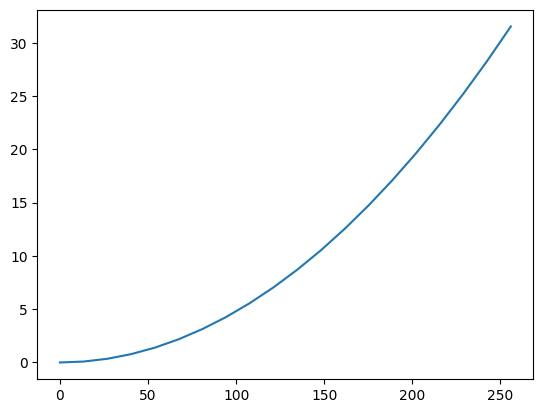

In [76]:
plt.plot(x0, z0)
plt.show()

In [77]:
q0=np.zeros(12*N)

In [78]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [79]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [80]:
root_ = root(static_func, q0, method='df-sane')

In [81]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.252e+01  1.252e+01 ...  0.000e+00  0.000e+00]
       x: [-5.393e+02 -5.258e+02 ...  0.000e+00  0.000e+00]
     nit: 308
    nfev: 1000
  method: df-sane

In [82]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [83]:
# q0 = root_.x                                            # start from static solution

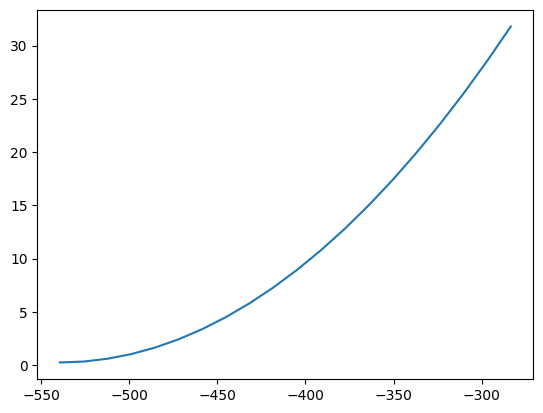

In [84]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [85]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [86]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [87]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [88]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [89]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [90]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [91]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [92]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=E, G=G, A=Ar, Iy=Iy_, Iz=Iz_, J=J_):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement
    
    vessel_move=np.zeros(len(X)*6)

    d, f = FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [93]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [94]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.91602516e-03, -1.47705078e-02,  8.10241699e-03],
       [-5.94139099e-04, -2.60620117e-02, -1.14898682e-02],
       [-1.54876709e-03, -1.84078217e-02,  1.33819580e-02],
       [-6.26683235e-04, -4.02832031e-03, -1.26190186e-02],
       [-5.77735901e-03,  1.02539062e-02,  1.16882324e-02],
       [ 1.41525269e-03,  1.83715820e-02, -7.14111328e-03],
       [-1.34849548e-03,  1.69487000e-02, -2.86865234e-03],
       [ 9.24587250e-04,  6.65283203e-03,  7.27462769e-03],
       [ 1.41906738e-03, -8.54492188e-04, -1.06201172e-02],
       [-2.16674805e-03, -1.01318359e-02,  1.22070312e-02],
       [ 1.72424316e-03, -9.23156738e-03, -1.17797852e-02],
       [-1.10650063e-03, -3.66210938e-03,  8.20159912e-03],
       [ 7.51495361e-04,  4.88281250e-04, -5.12695312e-03],
       [-7.62939453e-05,  5.27954102e-03,  1.34277344e-03],
       [-7.26022741e-04,  3.57391951e-03,  8.84012124e-04],
       [ 8.30962975e-04, -5.29665147e-04

In [95]:
mom

array([[ 2.30503082e-03, -2.45982409e-03, -1.22070312e-03],
       [ 4.63676453e-03,  1.03759766e-02, -1.80053711e-03],
       [ 1.17568970e-02, -4.11224365e-03,  1.22070312e-03],
       [ 1.13754272e-02,  6.46972656e-03, -1.34277344e-03],
       [ 5.09643555e-03,  1.20010376e-02,  3.41796875e-03],
       [ 1.65557861e-03,  7.93457031e-03,  8.10241699e-03],
       [-4.71496582e-03,  4.93621826e-03, -2.44140625e-04],
       [-6.36291504e-03, -3.17382812e-03, -2.44140625e-03],
       [-2.68554688e-03,  1.00440979e-02, -4.39453125e-03],
       [ 2.13623047e-04, -4.15039062e-03, -1.10473633e-02],
       [ 1.55639648e-03, -2.21633911e-03,  1.95312500e-03],
       [ 6.10351562e-04, -2.44140625e-03,  9.09423828e-03],
       [ 7.32421875e-04, -2.43759155e-03,  7.32421875e-03],
       [ 3.61442566e-04, -1.83105469e-03,  6.71386719e-04],
       [-1.06811523e-03,  3.77655029e-04,  2.19726562e-03],
       [-2.21780581e-04, -4.48688106e-03, -5.33384679e-03],
       [-5.91772532e-04,  1.10333406e-02

In [96]:
angle

array([[-3.76889726e-01,  2.45278390e-02, -4.16011777e-02],
       [-3.76889726e-01,  2.43310318e-02, -4.16011117e-02],
       [-3.76547344e-01,  2.37393922e-02, -4.15942834e-02],
       [-3.75520370e-01,  2.27503846e-02, -4.15608037e-02],
       [-3.73466932e-01,  2.13612715e-02, -4.14675300e-02],
       [-3.70045675e-01,  1.95691114e-02, -4.12680755e-02],
       [-3.64915922e-01,  1.73707555e-02, -4.09028223e-02],
       [-3.57737846e-01,  1.47628450e-02, -4.02989369e-02],
       [-3.48172634e-01,  1.17418081e-02, -3.93703904e-02],
       [-3.35882652e-01,  8.30385719e-03, -3.80179818e-02],
       [-3.20531610e-01,  4.44498551e-03, -3.61293633e-02],
       [-3.01784715e-01,  1.60964156e-04, -3.35790706e-02],
       [-2.79308834e-01, -4.55266115e-03, -3.02285544e-02],
       [-2.52772643e-01, -9.70057339e-03, -2.59262158e-02],
       [-2.21846778e-01, -1.52876876e-02, -2.05074435e-02],
       [-1.86203984e-01, -2.13191543e-02, -1.37946536e-02],
       [-1.45519254e-01, -2.78003632e-02

### Vessle Simulation

In [97]:
sampleTime = 0.01              # sample time [seconds]
Number = 60000                      # number of samples

In [98]:
Number*sampleTime

600.0

In [99]:
vehicle=semisub('DPcontrol',1,-1,0.0,0,0)

In [100]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [101]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

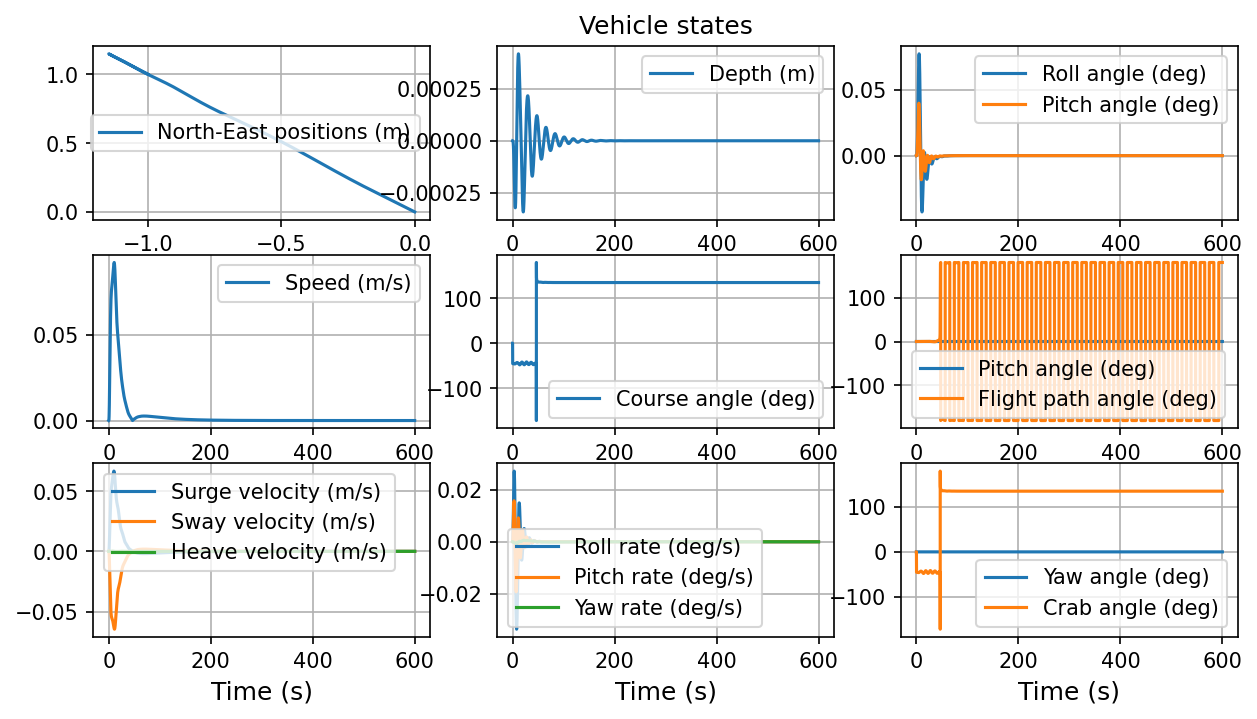

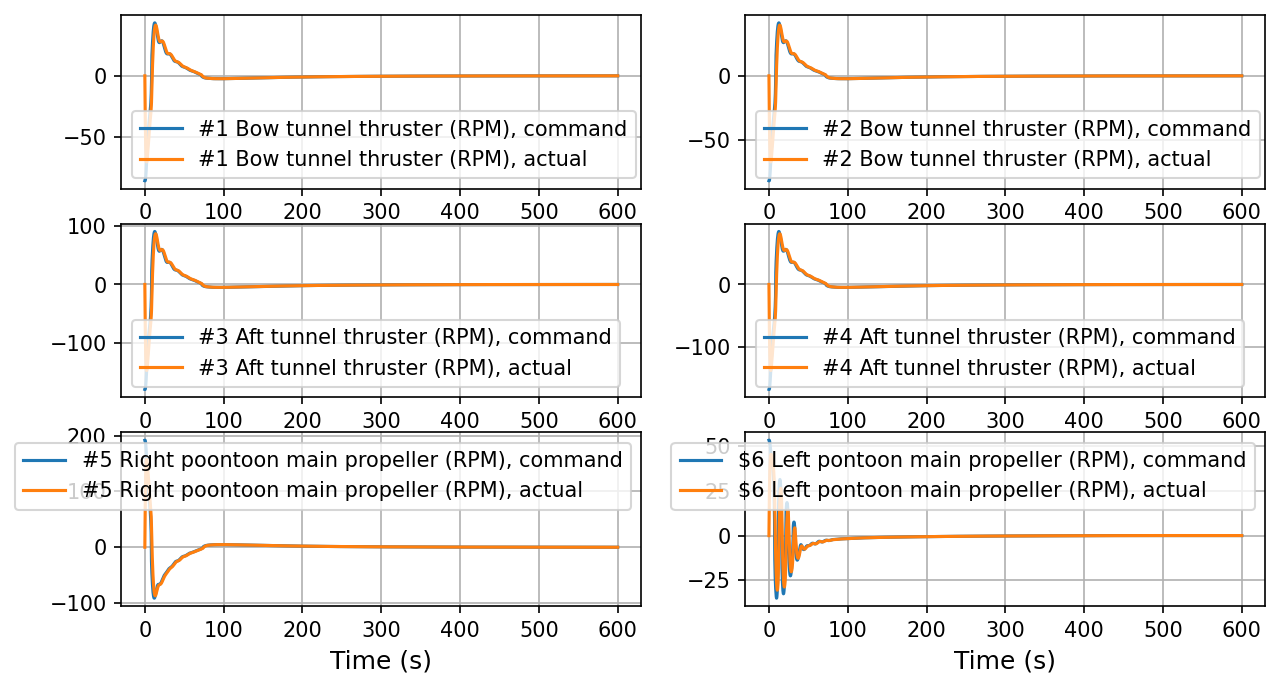

In [102]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [103]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

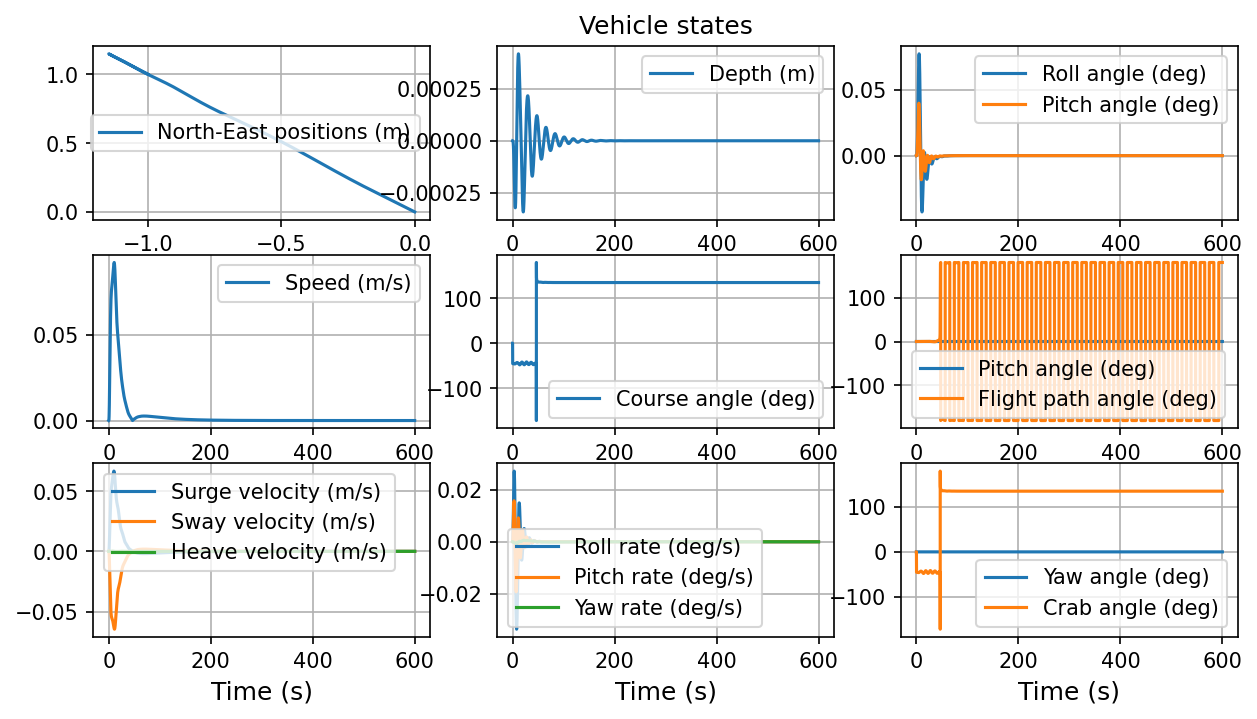

In [104]:
plotVehicleStates(simTime, simData, 3)

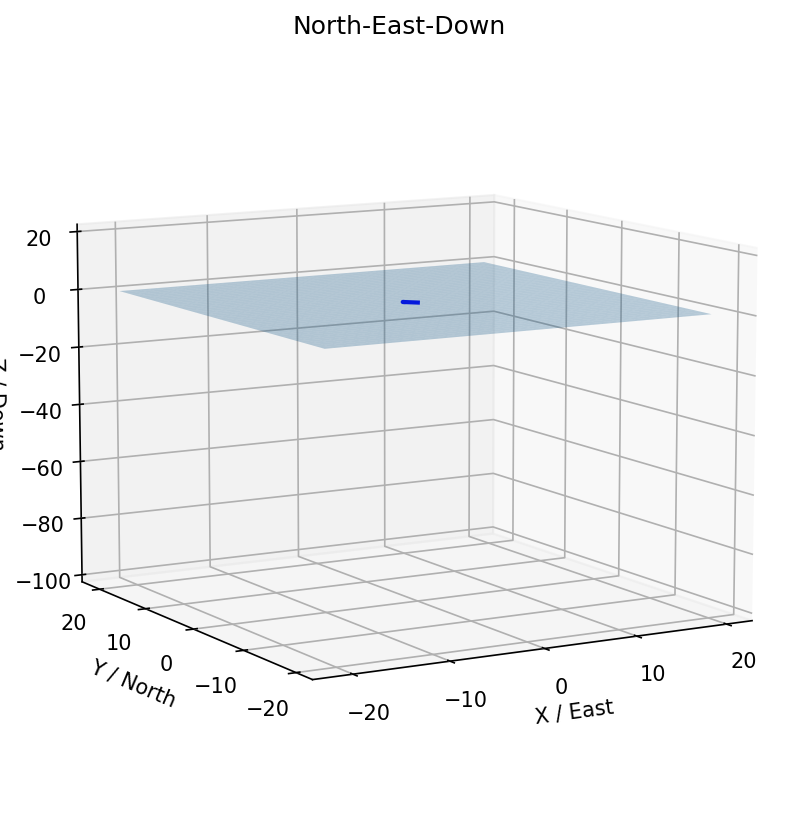

In [105]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [106]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [107]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0
        self.max_axial_tension = 0
        self.max_bending_strain = 0
        self.my_iter = 0

In [108]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [109]:
# V_rho=np.zeros(Jrho0.shape)
# np.fill_diagonal(V_rho, vessel_inertia)

In [110]:
# M_t=inert(vessel_mass*9.81,mp*9.81, x0)
# Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [111]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = (phi_ve - T.phi_ve)
    vessel_movement[4] = (theta_ve - T.theta_ve)
    vessel_movement[5] = (psi_ve - T.psi_ve)

    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall-clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()   
         
    
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
   
   
    ax=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET),ne(x, y, z, φ, θ, ψ)))/(mp*9.81*h)
    T.max_axial_tension=max(T.max_axial_tension, ax)
    
    W = 3.14*(d0**4-dI**4)/(32*d0)
    ben=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET), 
                         me(φ, θ, ψ, φ, θ, ψ)))/(mp*9.81*np.sqrt((x[-1]-x0_[-1])**2+
                                                                 (y[-1]-0)**2+(z[-1]-z0_[-1])**2)**2)
    T.max_bending_strain=max(T.max_bending_strain,(ben/W)/E)
    T.my_iter+=1
    
    return ans

In [112]:
T_ = MyTime()

# initial conditions - to control dynamics
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.001257*i/N for i in range(N)]))

In [113]:
startTime1 = datetime.now()
us_ = solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  2.1256512351911298e-07  Iteration wall-clock time:  0:00:00.799981
Physical time:  1.0038542355115931  Iteration wall-clock time:  0:00:46.766013
Physical time:  2.025324526787569  Iteration wall-clock time:  0:00:48.242340
Physical time:  3.0046430186428403  Iteration wall-clock time:  0:00:32.460951
Physical time:  4.030889846854456  Iteration wall-clock time:  0:00:28.841626
Physical time:  5.034925053646613  Iteration wall-clock time:  0:00:31.475926
Physical time:  6.002106895244954  Iteration wall-clock time:  0:00:29.450422
Physical time:  7.013418495861685  Iteration wall-clock time:  0:00:37.944755
Physical time:  8.004684460644116  Iteration wall-clock time:  0:00:29.800967
Physical time:  9.012077960417006  Iteration wall-clock time:  0:00:31.606668
0:05:57.300435


In [114]:
# max axial tension
T_.max_axial_tension

124.94425974776716

In [115]:
T_.max_axial_tension*mp*9.81*h

2897562.336728909

In [116]:
# max bending strain
T_.max_bending_strain

7.352029431641399e-09

In [117]:
# max bending moment 
W = 3.14*(d0**4-dI**4)/(32*d0)
T_.max_bending_strain*W*E

5.974670797155525

### Results

In [118]:
fin=us_

In [119]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.126e-05 ...  9.958e+00  1.000e+01]
        y: [[ 0.000e+00  6.088e-25 ...  1.954e-05  1.969e-05]
            [ 1.347e+01  1.347e+01 ...  1.336e+01  1.336e+01]
            ...
            [ 0.000e+00 -1.420e-18 ...  1.716e-10  1.674e-10]
            [ 0.000e+00 -8.574e-19 ...  5.867e-12  5.822e-12]]
      sol: None
 t_events: None
 y_events: None
     nfev: 938
     njev: 0
      nlu: 0

In [120]:
t=fin.t

In [121]:
fin=fin.y.T

In [122]:
t.shape, fin.shape

((147,), (147, 240))

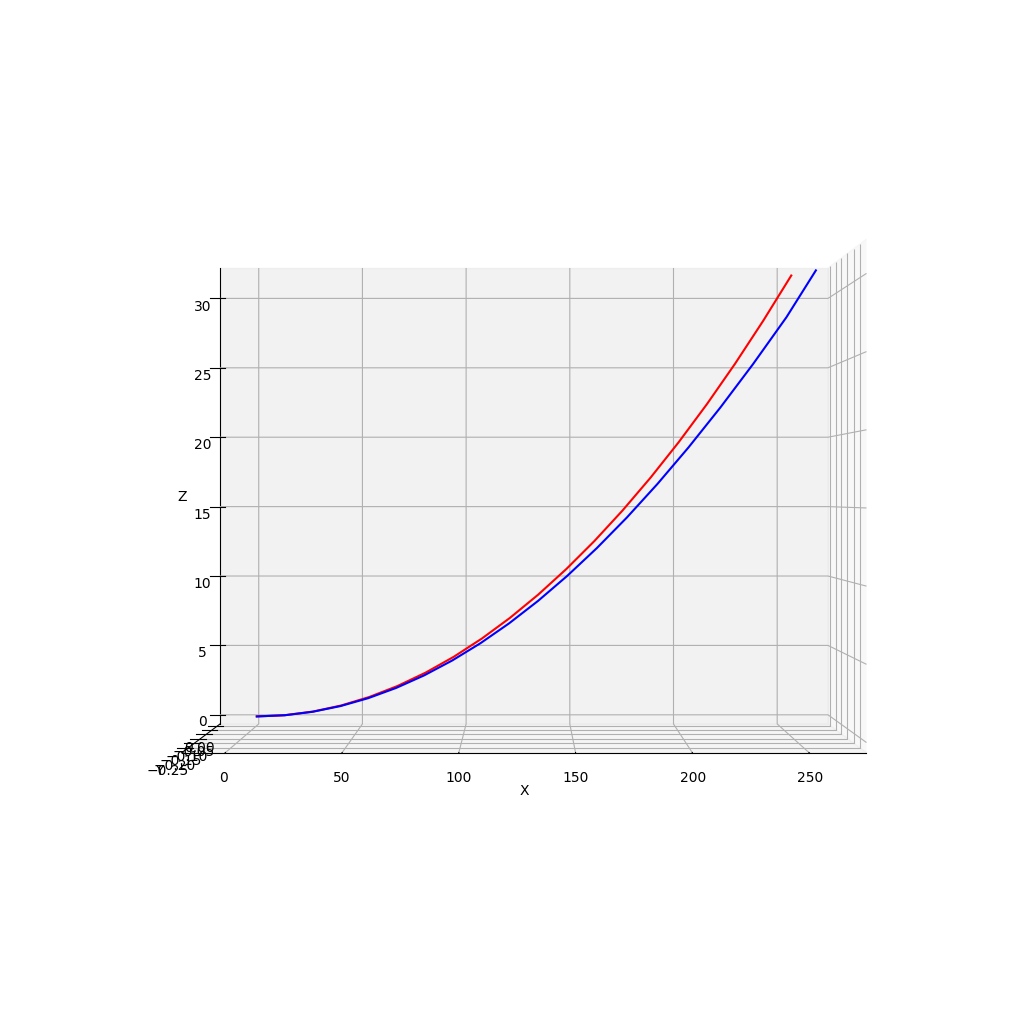

In [123]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [124]:
X,Y,Z

(array([1.96919278e-05, 1.33615204e+01, 2.67526447e+01, 4.01602104e+01,
        5.35813337e+01, 6.70171981e+01, 8.04714204e+01, 9.39483434e+01,
        1.07446236e+02, 1.20953660e+02, 1.34460106e+02, 1.47961124e+02,
        1.61456715e+02, 1.74948589e+02, 1.88438437e+02, 2.01926784e+02,
        2.15415015e+02, 2.28903937e+02, 2.42394301e+02, 2.53852379e+02]),
 array([ 1.96795365e-09,  3.42435314e-04, -5.79255456e-04, -3.25023662e-03,
        -7.69491044e-03, -1.38823765e-02, -2.17964601e-02, -3.14318222e-02,
        -4.27876745e-02, -5.58669581e-02, -7.06643324e-02, -8.71797236e-02,
        -1.05412189e-01, -1.25359985e-01, -1.47005049e-01, -1.70377346e-01,
        -1.95425921e-01, -2.22182859e-01, -2.50602290e-01, -2.78342994e-01]),
 array([-1.33258087e-03,  8.30019994e-02,  3.35681373e-01,  7.56744973e-01,
         1.34655639e+00,  2.10546989e+00,  3.03392143e+00,  4.13245675e+00,
         5.40141693e+00,  6.84052899e+00,  8.44931685e+00,  1.02274523e+01,
         1.21748323e+01,  1.

In [125]:
X0,Y0,Z0

(array([  0.        ,  13.4657417 ,  26.93148341,  40.39722511,
         53.86296681,  67.32870851,  80.79445022,  94.26019192,
        107.72593362, 121.19167532, 134.65741703, 148.12315873,
        161.58890043, 175.05464213, 188.52038384, 201.98612554,
        215.45186724, 228.91760894, 242.38335065, 255.84909235]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.08691711,  0.34768291,  0.78234086,  1.39096341,
         2.17365196,  3.13053697,  4.26177789,  5.56756325,  7.04811064,
         8.70366682, 10.53450766, 12.54093829, 14.72329307, 17.08193569,
        19.61725922, 22.32968617, 25.21966855, 28.28768799, 31.53425578]))

In [126]:
us=fin.T

In [127]:
us.shape

(240, 147)

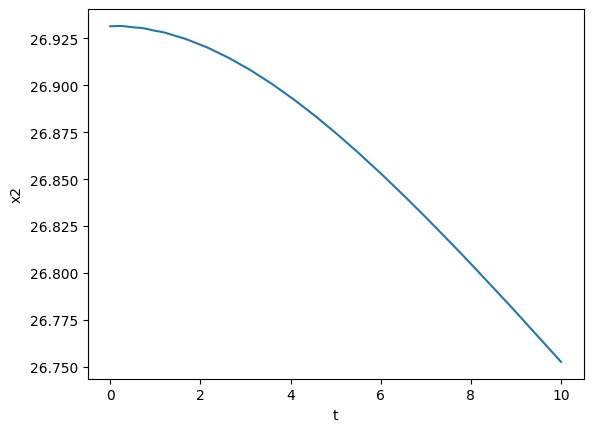

In [128]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

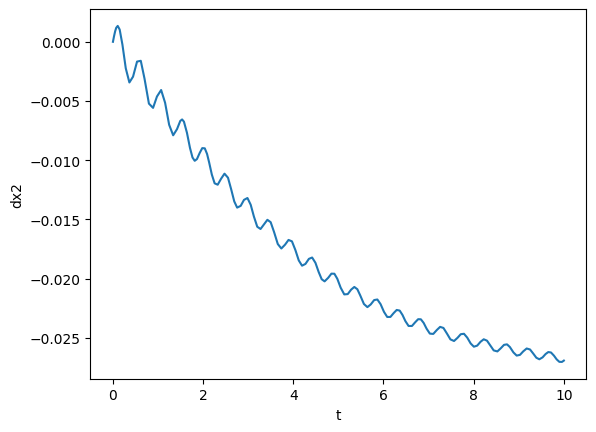

In [129]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

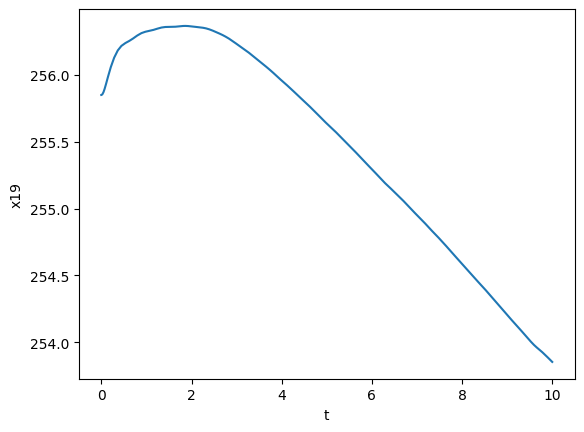

In [130]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

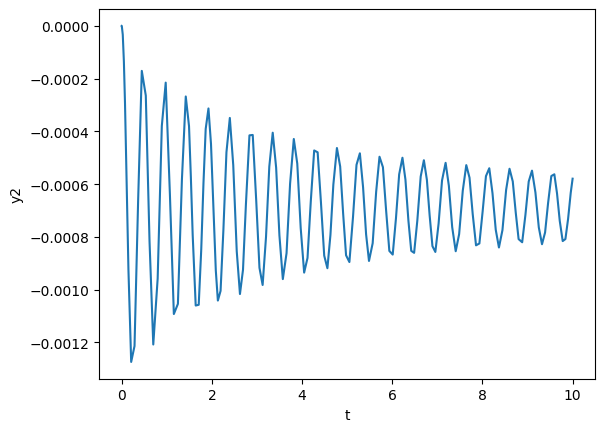

In [131]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

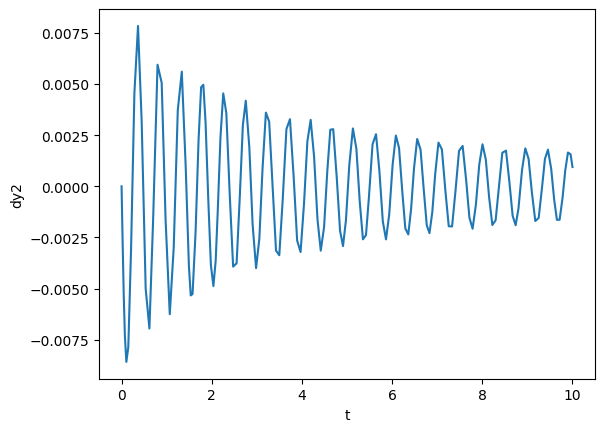

In [132]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

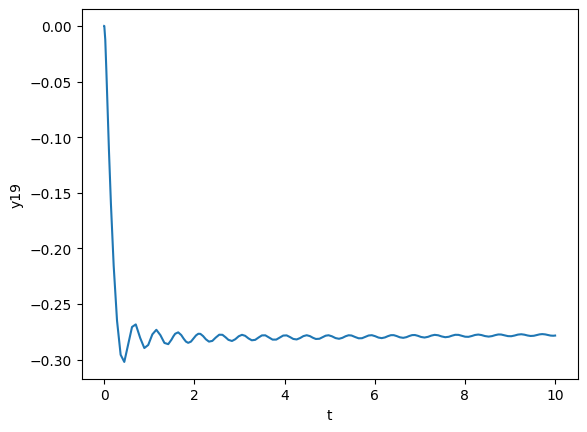

In [133]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

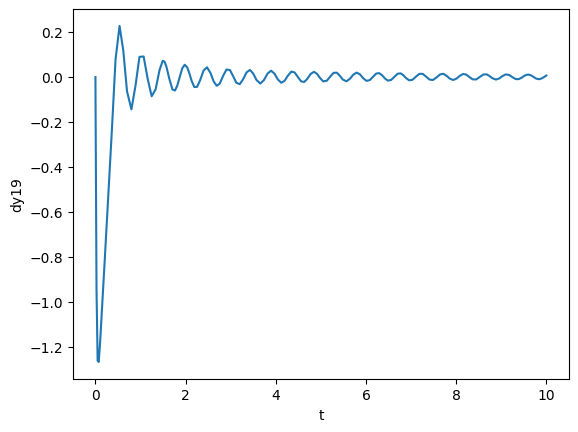

In [134]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

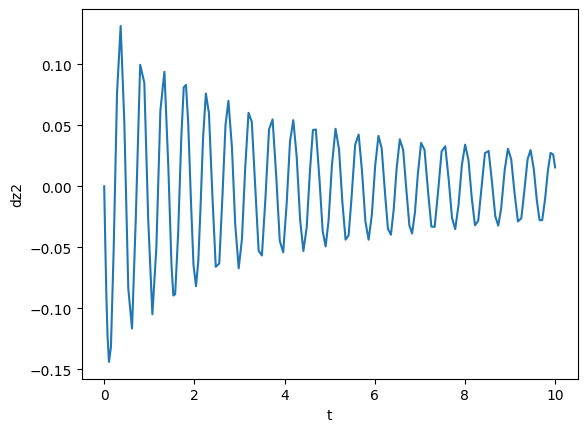

In [135]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

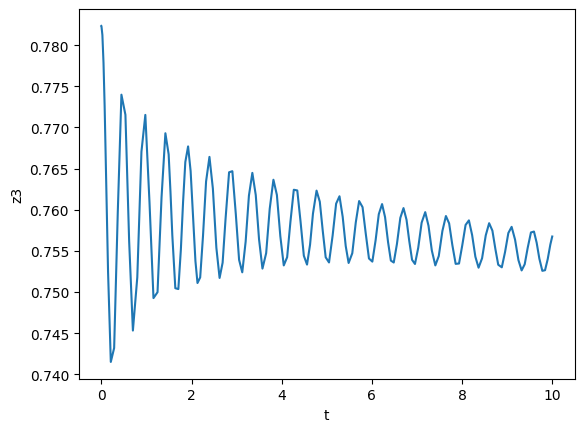

In [136]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

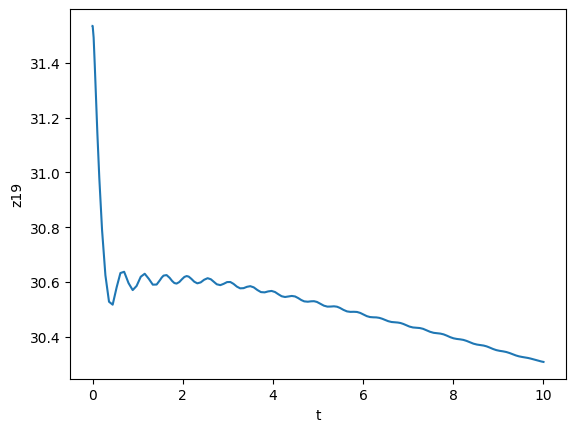

In [137]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

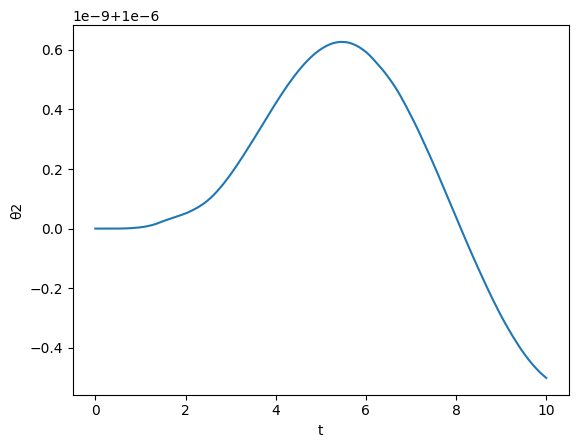

In [138]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

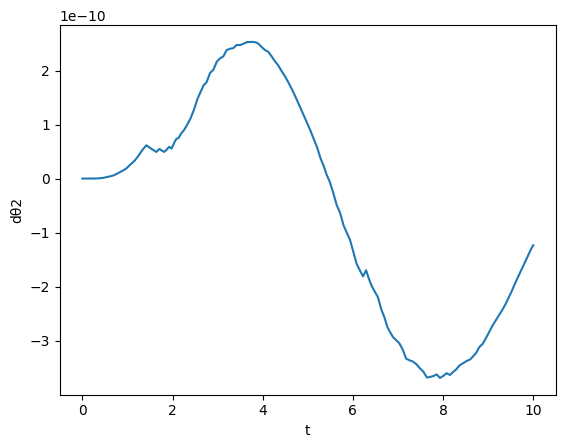

In [139]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

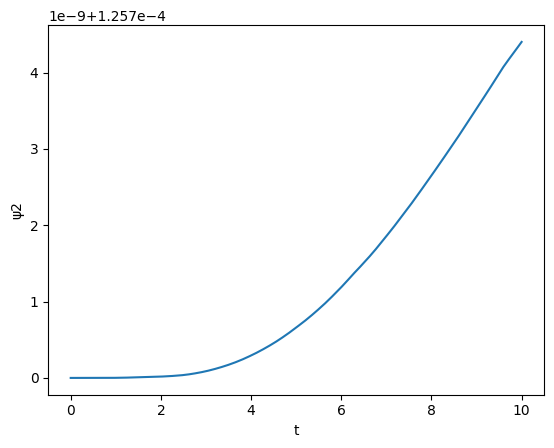

In [140]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

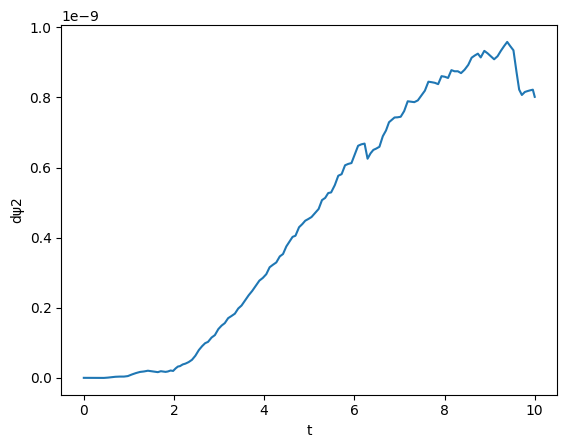

In [141]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

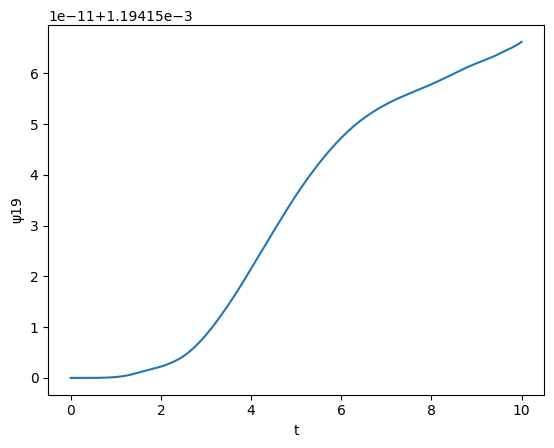

In [142]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()

In [143]:
X010=us.T[:,0*N:1*N]

In [144]:
Y010=us.T[:,2*N:3*N]

In [145]:
Z010=us.T[:,4*N:5*N]

In [146]:
# simulation = np.stack([X010,Y010,Z010],axis=2) 

# FPS = 30                      
# frame_duration = 1000 / FPS

# frames = []
# for t in range(simulation.shape[0]):
#     x = simulation[t,:,0]
#     y = simulation[t,:,1]
#     z = simulation[t,:,2]

#     frames.append(go.Frame(
#         data=[
#             go.Scatter3d(
#                 x=x, y=y, z=z,
#                 mode="lines+markers",
#                 marker=dict(size=5, color=list(range(12)), colorscale="Viridis"),
#                 line=dict(width=4)
#             )
#         ],
#         name=f"t={t}"
#     ))

# # First frame
# x0, y0, z0 = simulation[0,:,0], simulation[0,:,1], simulation[0,:,2]

# fig = go.Figure(
#     data=[go.Scatter3d(x=x0, y=y0, z=z0, mode="lines+markers")],
#     frames=frames
# )

# # Animation controls
# fig.update_layout(
#     title="Pipeline Simulation ",
#     scene=dict(
#         xaxis_title="X",
#         yaxis_title="Y",
#         zaxis_title="Z",
#         xaxis=dict(range=[0, 300]),
#         yaxis=dict(range=[-50, 50]),
#         zaxis=dict(range=[0, 40]),
#         aspectmode="data",
       
#     ),
#     updatemenus=[{
#         "type": "buttons",
#         "buttons": [
#             {
#                 "label": "Play",
#                 "method": "animate",
#                 "args": [None, {"frame": {"duration": frame_duration, "redraw": True}}]
#             },
#             {
#                 "label": "Pause",
#                 "method": "animate",
#                 "args": [[None], {"frame": {"duration": 0}}]
#             }
#         ]
#     }]
# )

# fig.show()